# Sentiment Analysis on IMDB Movie Reviews
This project is one of my Deep Learning projects. For this project, we have the [IMDB](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) dataset that contains the text of 50,000 movie reviews from the Internet Movie Database.

The goal of this project is apply [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to classifiy movie reviews as positive or negative based on the text of the review.

In [0]:
# Import the libraries
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

## Loading the Data
We can import and load the IMDB dataset directly from TensorFlow datasets. Originally, the dataset is split into 25,000 reviews for training and 25,000 reviews for testing. We will split the training set with a ratio of 60:40. So, we will end up with 15,000 samples for training, 10,000 samples for validation and 25,000 samples for testing.


In [0]:
# Load and split the data
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)



```
`# This is formatted as code`
```

Let's view the first 5 samples and labels of our training data. 

In [0]:
train_samples_batch, train_labels_batch = next(iter(train_data.batch(5)))

In [4]:
# View the first 5 samples
train_samples_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [5]:
# View the first 5 labels
train_labels_batch

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 1, 1])>

As we can see, each sample is a sentence representing the movie review and the label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

## Building the Model
Here, we will apply transfer learning by using a pre-trained text embedding model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1). Let's first create a Keras layer that uses this TensorFlow Hub model to embed the sentences.

In [0]:
# Create an embedding layer
embedding =  "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                          dtype=tf.string, trainable=True)

### Configuring the Layers
Now, we can build the full model by configuring the layers. The first layer is the embedding layer using the pre-trained model from TensorFlow Hub. The next layer will be a `tf.keras.layers.Dense` layer with 16 hidden units. Finally, the last layer is another `tf.keras.layers.Dense` with a single output node.

In [0]:
# Build the model
model = tf.keras.Sequential()

# Configure the layers
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [8]:
# View the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model
Before training the model, we need to compile the model with the following settings:
- Loss function: This measures how accurate the model is during training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we will use the binary crossentropy loss function.
- Optimizer: This is how the model is updated based on the data it sees and its loss function. We are going to use Adam, which is an optimization algorithm based on adaptive estimation of first-order and second-order moments.
- Metrics: Used to monitor the training and testing steps. Here we will use accuracy, the fraction of the images that are correctly classified.

In [0]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Fitting the Model
Now, we can use the model.fit method to fits the model to the training data. We will train the model for 20 epochs in mini-batches of 512 samples. During the training process, we will also monitor the model's loss and accuracy on the 10,000 samples from the validation set.

In [10]:
# Fit the model
history = model.fit(train_data.shuffle(10000, seed=0).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512))

Epoch 1/20
30/30 [==============================] - 3s 110ms/step - loss: 0.7683 - accuracy: 0.4617 - val_loss: 0.7087 - val_accuracy: 0.5327
Epoch 2/20
30/30 [==============================] - 3s 105ms/step - loss: 0.6661 - accuracy: 0.5996 - val_loss: 0.6365 - val_accuracy: 0.6417
Epoch 3/20
30/30 [==============================] - 3s 112ms/step - loss: 0.6124 - accuracy: 0.6719 - val_loss: 0.5974 - val_accuracy: 0.6825
Epoch 4/20
30/30 [==============================] - 3s 106ms/step - loss: 0.5738 - accuracy: 0.7091 - val_loss: 0.5654 - val_accuracy: 0.7137
Epoch 5/20
30/30 [==============================] - 3s 108ms/step - loss: 0.5385 - accuracy: 0.7417 - val_loss: 0.5333 - val_accuracy: 0.7424
Epoch 6/20
30/30 [==============================] - 3s 105ms/step - loss: 0.5007 - accuracy: 0.7730 - val_loss: 0.5005 - val_accuracy: 0.7698
Epoch 7/20
30/30 [==============================] - 3s 107ms/step - loss: 0.4630 - accuracy: 0.7976 - val_loss: 0.4678 - val_accuracy: 0.7891
Epoch 

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 94% on the training data and 87% on validation data.

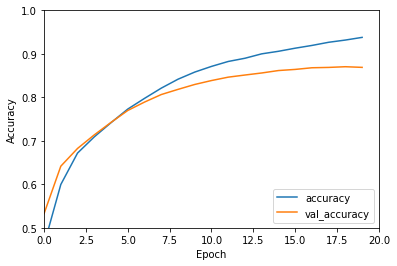

In [11]:
import matplotlib.pyplot as plt

# Create the accuracy plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([0, 20])
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

## Evaluating the Model
Next, compare how the model performs on the test data.

In [12]:
test_loss, test_acc = model.evaluate(test_data.batch(512), verbose=2)

49/49 - 3s - loss: 0.3208 - accuracy: 0.8638



It turns out that the accuracy on the test dataset is a little less than the accuracy on the validation data.

## Making Predictions
Now that we have our model trained, we can try to make some predictions.

In [13]:
# Predict on a positive movie review
model.predict(['This is the best movie I have ever seen!',
               'This movie is very horrible! The acting is very poor!'])

array([[0.91713476],
       [0.0351524 ]], dtype=float32)

Since the first review has a value closer to 1, the model classifies this as a positive review. On the other hand, the second review has a value closer to 0, so the model classifies this as a negative review.